In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client
from ase.io import read

(walkthrough:prism)=
# PRISM

Multslice simulations of STEM images is computationally expensive because the exit wave function has to be calculated from scratch at each probe position. abTEM uses parallization to mitigate this, an alternative, that does not require more hardware, is to use the PRISM algorithm {cite}`prism`. At zero cost to accuracy, PRISM almost always speeds up simulations of images with many probe positions. By introducing approximations in the form of Fourier space interpolation, PRISM can reach speedups of several 100x at a minor cost to the accuracy.

```{seealso}
Our PRISM quickstart example provides a basic template for doing STEM simulations with PRISM in *abTEM*.
```

## The PRISM scattering matrix

We derive the PRISM algorithm from the perspective of writing the (discretized) probe wave function as an expansion of plane waves.

$$
    \psi(\vec{r}) = \sum_{nm} C_{nm} S_{nm}
$$

where

$$
    S_{nm} = \exp(-2\pi i \vec{q}_{nm} \cdot \vec{r})
$$

is a plane wave with a wave vector $\vec{q}_{nm}$ that (due to discretization) must fulfill

$$
    \vec{q}_{nm} = (n \Delta q, m \Delta q) \quad ,
$$ 

where $\Delta q$ is the Fourier space sampling rate. The complex expansion coefficients $C_{nm}$ may be chosen to select a specified probe position and/or phase error. Since the Fourier space probe wave function is zero beyond the convergence semi-angle, we may limit the number of terms in the expansion by the semiangle cutoff $\alpha_{cut}$. Thus only the terms fulfilling 

$$
    \sqrt{n ^ 2 + m ^ 2} \lambda \Delta_q \leq \alpha_{cut}
$$ (eq:prism_cutoff)

needs to be included in the expansion.

We use the symbol $\mathcal{M}$ to represent the application of the multislice algorithm to a wave function (see Eq. `eq`{eq:multislice_symbol} in our walkthrough on the multislice algorithm), thus the exit wave is given by 

$$
    \phi_{exit}(\vec{r}) = \mathcal{M} \sum_{nm} C_{nm} S_{nm} = \sum_{nm} C_{nm} \mathcal{M} S_{nm} \quad ,
$$ (eq:prism)

where the second equality just uses that the multislice operator is linear (following from the linearity of convolutions).

The PRISM algorithm for STEM simulations may be summarised as two consecutive stages: 

**Multislice stage:** Build the PRISM scattering matrix by applying the multislice algorithm to each plane wave in the expansion, i.e. calculate the set of waves $\mathcal{M} S_{nm}$.

**Reduction stage:** For each probe position, perform the reduction in Eq. {eq}`eq:prism` with a set of expansion coefficients determined by the probe position and phase aberrations.

## The `SMatrix`

We import the atomic model of the SrTiO<sub>3</sub>/LaTiO<sub>3</sub> interface created [here](walkthrough:atomic_models) and make a `Potential`.

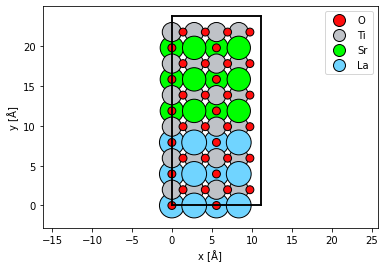

In [3]:
atoms = read("../walkthrough/data/STO_LTO.cif")

potential = abtem.Potential(atoms, gpts=(304, 608))

abtem.show_atoms(atoms, legend=True);

In *abTEM*, the PRISM scattering matrix (i.e. the set of waves $\mathcal{M} S_{nm}$) is represented by the `SMatrix`. The expansion cutoff angle, $\alpha_{max}$, is given as `planewave_cutoff`. In addition to $\alpha_{max}$, the number of plane wave in the expansion increases with the energy and the extent of the potential, because they, respectively, decrease $\lambda$ and $\Delta_q$ in Eq. {eq}`eq:prism_cutoff`.

We create an `SMatrix` representing the SrTiO<sub>3</sub>/LaTiO<sub>3</sub> model for an energy of $150 \ \mathrm{keV}$ and an expansion cutoff angle of $20 \ \mathrm{mrad}$.

In [4]:
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    planewave_cutoff=20,
)

We can `build` the `SMatrix` to produce an `SMatrixArray`. The `SMatrixArray` wraps a 3d `numpy` array where the first dimension indexes $S_{nm}$ (running over both indices $n$ and $m$), the last two dimensions represents the $x$ and $y$ axis of the waves.

We see that the expansion of our probe requires 375 plane waves.

In [5]:
s_matrix_array = s_matrix.build()

s_matrix_array.waves

```{note}
The number of grid points of the waves is smaller than the `Potential` by a factor of $2 / 3$. This is because the array representing the PRISM S-Matrix is downsampled to the angle of the anti-aliasing aperture after the multislice stage. This is done to save memory, but can be disabled by setting `downsample=False` when creating the `SMatrix`.
```

We show a small selection of the expansion wave functions ($\mathcal{M} S_{nm}$) below.

[########################################] | 100% Completed | 2.08 sms


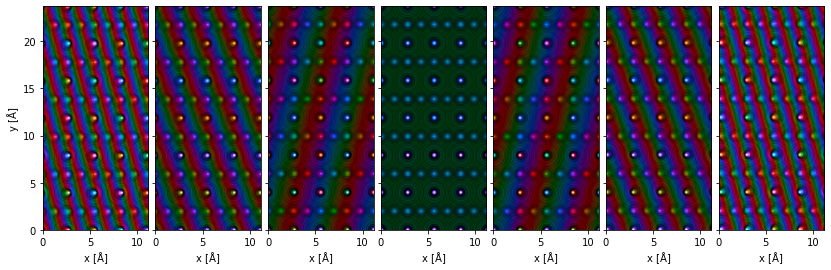

In [6]:
s_matrix.build(max_batch=1).waves[1::62].images().show(
    explode=True,
    panel_titles=False,
    figsize=(14, 6),
);

The number of plane waves should be compared to the number of probe positions required to scan over the extent of the potential at Nyquist sampling.

In [7]:
sampling = abtem.transfer.nyquist_sampling(
    s_matrix.planewave_cutoff, s_matrix.energy
)

scan = abtem.GridScan.from_fractional_coordinates(potential, sampling=sampling)

print(f"Number of probe positions: {len(scan)}")
print(f"Number of plane waves: {len(s_matrix)}")
print(f"Ratio: {len(scan) / len(s_matrix):.1f}")

Number of probe positions: 2015
Number of plane waves: 375
Ratio: 5.4


Thus, PRISM (without approximations) requires 5.4 times fewer multislice steps than the conventional multislice algorithm. 

This factor is an upper bound on possible speedup as PRISM also requires the reduction stage. To perform the reduction we call `scan` with the `GridScan` defined above and an `AnnularDetector` to detect the exit waves as the expansion is reduced with varying `C_{nm}`. 

We also call `compute` which in this case will compute the full task graph of both the multislice and reduction stage. 

In [8]:
detector = abtem.AnnularDetector(inner=50, outer=150)

measurement = s_matrix.scan(scan=scan, detectors=detector).compute()

[########################################] | 100% Completed | 46.23 ss


We can now show the resulting HAADF image.

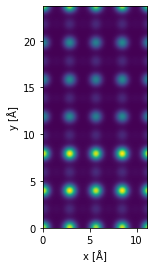

In [9]:
measurement.interpolate(0.1).gaussian_filter(.3).show();

The reduction stage is typically significantly faster than the multislice stage, however, this depends completely on the number of slices in the potential. Using PRISM the present example took about 1 min 30s on a mid-range laptop, while the equivalent conventional multislice algorithm took 6 min, hence the actual speedup from using PRISM was about a factor of 4.

## PRISM interpolation

The real speedup with PRISM comes when introducing interpolation. Choosing the interpolation factors $(f_n, f_m)$ the wave vectors should fulfill 

$$
    \vec{q}_{nm} = (n f_n \Delta q, m f_m \Delta q) \quad ,
$$

hence we keep only every $f_n$'th and $f_m$'th wave vector. For example, for $(f_n, f_m) = (2, 1)$ we keep only every second wave vector, skipping every second of the $n$-indices. The total number of wave vectors is thus reduced by a factor $f_nf_m$.

We create the same `SMatrix` as we did in the preceding section, however, we create it with three different interpolation factors $(2, 1)$, $(4, 2)$ and $(8, 4)$.

In [10]:
s_matrix_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    planewave_cutoff=20,
    interpolation=(1, 2),
)

s_matrix_more_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    planewave_cutoff=20,
    interpolation=(2, 4),
)

s_matrix_very_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    planewave_cutoff=20,
    interpolation=(4, 8),
)

We run the PRISM algorithm with each of the interpolated scattering matrices.

In [11]:
measurement_interpolated = s_matrix_interpolated.scan(
    scan=scan, detectors=detector
).compute()
measurement_more_interpolated = s_matrix_more_interpolated.scan(
    scan=scan, detectors=detector
).compute()
measurement_very_interpolated = s_matrix_very_interpolated.scan(
    scan=scan, detectors=detector
).compute()

[########################################] | 100% Completed | 29.85 s
[########################################] | 100% Completed | 12.90 s
[########################################] | 100% Completed | 4.72 ss


We show a comparison of the results below. At a glance, we see that the results look identical up to and including an interpolation factor of $(2,4)$, however, at an interpolation factor of $(4, 8)$ visible errors are introduced.

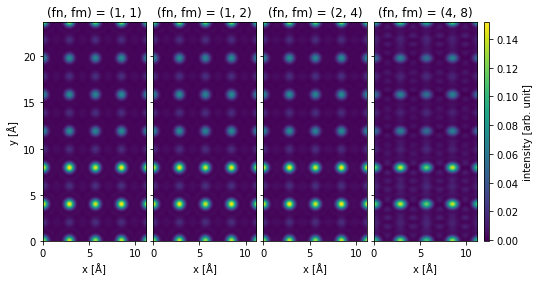

In [12]:
abtem.stack(
    [
        measurement,
        measurement_interpolated,
        measurement_more_interpolated,
        measurement_very_interpolated,
    ],
    (
        "(fn, fm) = (1, 1)",
        "(fn, fm) = (1, 2)",
        "(fn, fm) = (2, 4)",
        "(fn, fm) = (4, 8)",
    ),
).interpolate(0.1).show(
    explode=True,
    figsize=(8, 6),
    common_color_scale=True,
    cbar=True,
    image_grid_kwargs={"axes_pad": 0.1},
);

A quantitative comparison is shown below as the difference between the exact and interpolated as a percent of the maximum value. We see that the error is a couple of percent for the interpolation factors $(1,2)$ and $(2,4)$, which is probably well within the range of error source due to unknowns and implicit approximantions. The error of up to $15\ \%$ for the interpolation factor of $(4,8)$ is clearly too large for creating production quality simulations, but it  might be tolerated while dialing in other parameters. 

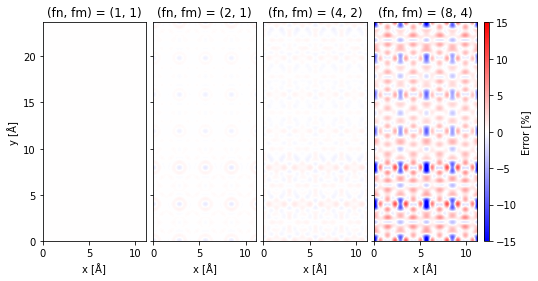

In [13]:
abtem.stack(
    [
        (measurement - measurement) / measurement.max() * 100,
        (measurement_interpolated - measurement) / measurement.max() * 100,
        (measurement_more_interpolated - measurement) / measurement.max() * 100,
        (measurement_very_interpolated - measurement) / measurement.max() * 100,
    ],
    (
        "(fn, fm) = (1, 1)",
        "(fn, fm) = (2, 1)",
        "(fn, fm) = (4, 2)",
        "(fn, fm) = (8, 4)",
    ),
).interpolate(0.1).show(
    explode=True,
    figsize=(8, 6),
    common_color_scale=True,
    cbar=True,
    image_grid_kwargs={"axes_pad": 0.1},
    cmap="bwr",
    cbar_labels="Error [%]",
    vmin=-15,
    vmax=15,
);

In the above we interpolated by twice the factor in $y$ compared to $x$. Interpolation effectively repeats the probe, hence the "window" that the repeated probes shrinks as interpolation increases. Hence when the potential extent is larger, we can interpolate by a larger factor before the probes starts to get squeezed.

### Choosing the interpolation

Choosing an appropriate interpolation factor can 

[########################################] | 100% Completed | 117.89 ms
[########################################] | 100% Completed | 107.06 ms
[########################################] | 100% Completed | 106.58 ms
[########################################] | 100% Completed | 109.37 ms


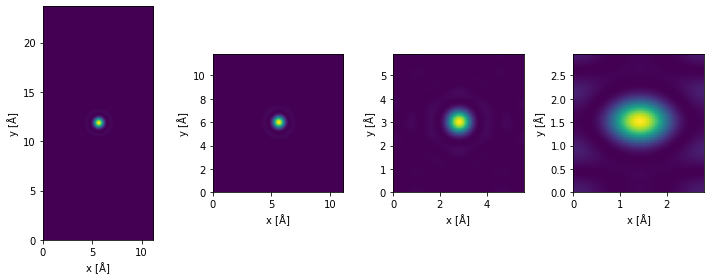

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 4))
s_matrix.dummy_probes().show(ax=ax1)
s_matrix_interpolated.dummy_probes().show(ax=ax2)
s_matrix_more_interpolated.dummy_probes().show(ax=ax3)
s_matrix_very_interpolated.dummy_probes().show(ax=ax4)
plt.tight_layout();

## PRISM with phase aberrations

In [15]:
defocus = abtem.distributions.uniform(0, 120, 5)

ctf = abtem.CTF(defocus=defocus, energy=150e3)

measurement_with_aberrations = s_matrix_interpolated.scan(
    scan=scan, detectors=detector, ctf=ctf
).compute()

[########################################] | 100% Completed | 49.48 s


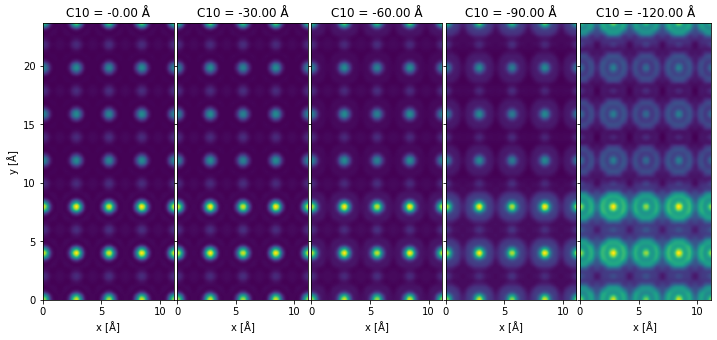

In [16]:
measurement_with_aberrations.interpolate(.1).show(
    explode=True,
    figsize=(18,5),
    image_grid_kwargs={"axes_pad": 0.05},
);

## Parallel reduction in *abTEM*

:::{admonition} {material-regular}`engineering;1.5rem;sd-mr-1` Currently Under Construction
:class: no-icon
Check back for more...
:::

## Memory issues

```{seealso}
See our [general introduction](walkthrough:parallelization) to parallelization in abTEM and our general [tips on performance](appendix:performance_tips).
```

The downside to PRISM is often an increased memory requirement which can sometimes be prohibitive. If you are running out memory, you should first check whether you can increase the interpolation factor or otherwise optimize the simulation parameters. Next, follow some of our general tips on performance, such as decreasing the number of workers. Finally, you can try to specify batch sizes manually, there 

* `max_batch_multislice`: Number of expansion plane waves in each run of the multislice algorithm
* `max_batch_reduction`: Number of probe positions per reduction operation

As an example, we setup a simulation with $20$ plane waves per multislice run and $200$ probe positions per reduction.
```python
measurement = s_matrix.scan(
    scan=scan, detectors=detector, max_batch_multislice = 20, max_batch_reduction = 200
)
```

GPU calculations requires additional considerations due to the limited memory of the devices. We can mitigate this by storing the SMatrix in host memory and only stream the necessary part to GPU, this is enabled by setting `store_on_host=True` on creating the `SMatrix`. You chould 

A known issue using the distributed scheduler and frozen phonons is ["root-task-overproduction"](https://github.com/dask/distributed/discussions/7128); essentially Dask may prioritize running the multislice stage for multiple frozen phonons configurations before any redcutions, thus leading to multiple configurations of the SMatrix being in memory simultaneously. We 

```python
import dask
dask.config.set({"distributed.scheduler.worker-saturation" : 1.1})
```

The abTEM PRISM implementation is still being tweaked, please create a GitHub issue if you continue to issues.